## excercise BOOSTING

Data: adult.csv, 
- Target: Income, Features: Preprocess
- Preprocess:
    - missing valueL simple imputer with constant
    - One hot encoding: relationship, race sex
    - binary encoding: workclass, marital status, occupation, native country
    - ordinal encoding: education (already encoded)
    - no treatment: numerical
    - out: fnlwgt

Random state 10, data splitting 70:30 stratify
- Tree: model tree(max depth 3) and compute precision, recall f1 in test set then compute the feature importances and show the tree
- ada boost: tree adaptive bossting (max depth 3, n estimator (b) 200, Learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances
- GBC: gradient bossting (max depth 3, n estimator (b) 200, learning rate 0.1) and compute precisin, recall, f1 in test set then compute the feature importances
- XGB: extreme gradient boosting(max depth 3, n estimator (B) 200, learning rate 0.1) and cimpute precision, recall, f1 in test set then compute the feature importances
- Model selection using grid search (tree, Tree adaboost, GBC, XGB) optimized by f1 and using stratified CV 5 Fold
- Hyperparameter tuning the winner (optimize B L max depth) optimized by f1 and using stratified cv 5 fold
- evaluate the tuned model in test set precision, recall, f1 score ROC< PRC nd compare the result (before after)

In [1]:
!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv(r'C:\Users\dheof\Desktop\Help\Purwadhika\Csv_Files\adult.csv')
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [5]:
df.replace('?', np.nan, inplace = True)

In [7]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## Preprocessing scenario

    - missing valueL simple imputer with constant
    - One hot encoding: relationship, race sex
    - binary encoding: workclass, marital status, occupation, native country
    - ordinal encoding: education (already encoded)
    - no treatment: numerical
    - out: fnlwgt

In [44]:
onehot = OneHotEncoder()
onehot_var = ['relationship', 'race', 'sex']

binary = ce.BinaryEncoder()
imputer = SimpleImputer(strategy = 'constant', fill_value = 'NC')
binary_pipe = Pipeline([
    ('imputer', imputer),
    ('encoder', binary)
])
binary_var = ['workclass', 'marital.status', 'occupation', 'native.country']


transformer = ColumnTransformer([
    ('onehot', onehot, onehot_var),
    ('binary', binary_pipe, binary_var)
], remainder = 'passthrough')

## Data splitting

In [122]:
x = df.drop(columns = ['fnlwgt', 'income', 'education'])
y = np.where(df['income'] == '>50K', 1, 0)

In [123]:
x_test, x_train, y_test, y_train = train_test_split(
    x,
    y,
    stratify = y,
    random_state = 10,
    test_size = 0.3
)

## Data transormation

In [124]:
x_train_prep = transformer.fit_transform(x_train)
x_test_prep = transformer.transform(x_test)

In [125]:
x_train_prep = pd.DataFrame(x_train_prep)
x_test_prep = pd.DataFrame(x_test_prep)

In [126]:
onehot_features = list(transformer.transformers_[0][1].get_feature_names())

In [127]:
binary_features = list(transformer.transformers_[1][1]['encoder'].get_feature_names())

In [128]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [129]:
features = onehot_features + binary_features + ['age','education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

In [130]:
features

['x0_Husband',
 'x0_Not-in-family',
 'x0_Other-relative',
 'x0_Own-child',
 'x0_Unmarried',
 'x0_Wife',
 'x1_Amer-Indian-Eskimo',
 'x1_Asian-Pac-Islander',
 'x1_Black',
 'x1_Other',
 'x1_White',
 'x2_Female',
 'x2_Male',
 '0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '3_5',
 '3_6',
 'age',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

In [131]:
len(features)

39

In [132]:
x_train_prep.columns = features
x_test_prep.columns = features

## Modeling

In [133]:
tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(x_train_prep, y_train)

DecisionTreeClassifier(max_depth=3)

In [134]:
y_pred = tree.predict(x_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     17303
           1       0.74      0.50      0.60      5489

    accuracy                           0.84     22792
   macro avg       0.80      0.72      0.75     22792
weighted avg       0.83      0.84      0.83     22792



In [137]:
def modeling_result(models):
    models.fit(x_train_prep, y_train)

    y_pred = models.predict(x_test_prep)
    print(classification_report(y_test, y_pred))
    fi = models.feature_importances_

    imp_table = pd.DataFrame({
        'imp' : fi,
    }, index = features)

    imp_table.sort_values(by = 'imp').plot(kind = 'barh', figsize = (12,12))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     17303
           1       0.74      0.50      0.60      5489

    accuracy                           0.84     22792
   macro avg       0.80      0.72      0.75     22792
weighted avg       0.83      0.84      0.83     22792



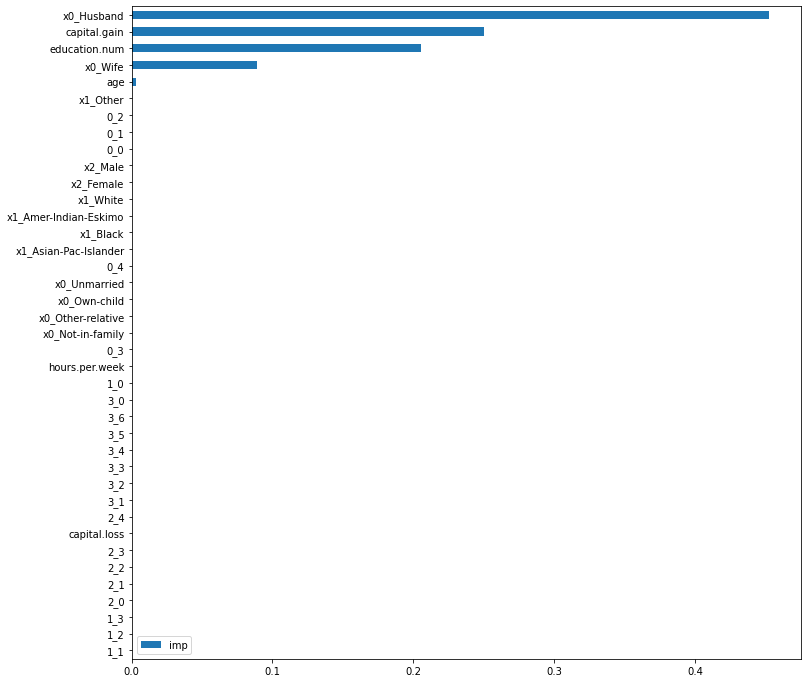

In [138]:
modeling_result(tree)

## adaptive boosting

In [140]:
tree = DecisionTreeClassifier(max_depth = 3)
tree_ada = AdaBoostClassifier(
    tree,
    n_estimators = 200,
    learning_rate = 0.1,
    random_state = 10 
    )

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17303
           1       0.76      0.64      0.69      5489

    accuracy                           0.86     22792
   macro avg       0.82      0.79      0.80     22792
weighted avg       0.86      0.86      0.86     22792



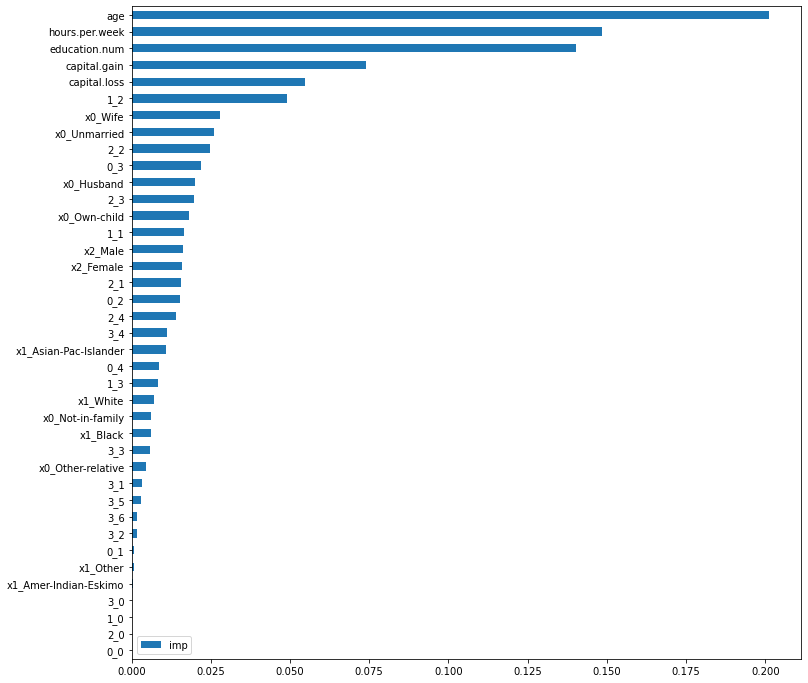

In [141]:
modeling_result(tree_ada)

## Gradient Boosting

In [142]:
model_gbc = GradientBoostingClassifier(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 3,
    random_state = 10
)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     17303
           1       0.76      0.64      0.69      5489

    accuracy                           0.87     22792
   macro avg       0.83      0.79      0.80     22792
weighted avg       0.86      0.87      0.86     22792



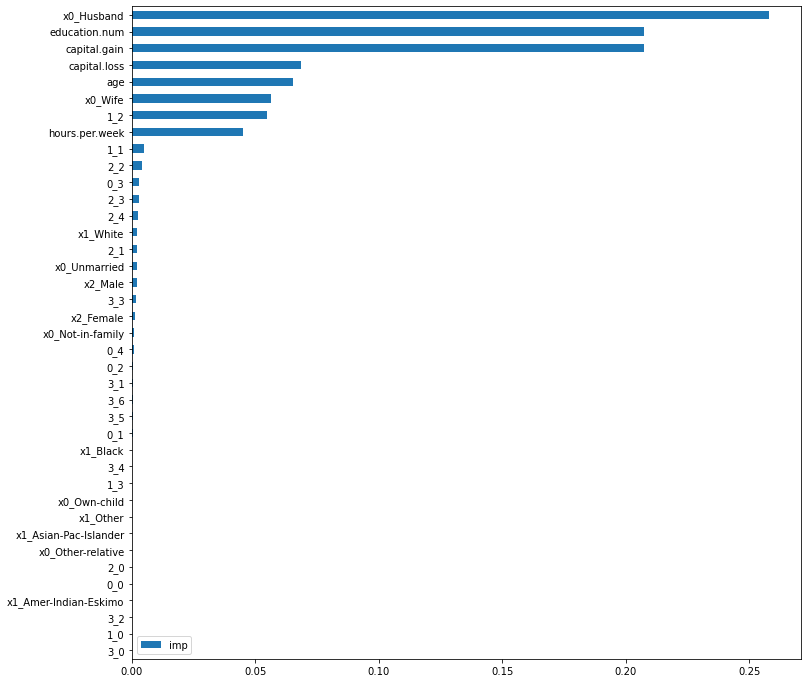

In [144]:
modeling_result(model_gbc)

## extreme boost

In [145]:
model_xgb = XGBClassifier(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 3,
    random_state = 10
)

[12:12:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     17303
           1       0.77      0.63      0.69      5489

    accuracy                           0.86     22792
   macro avg       0.83      0.78      0.80     22792
weighted avg       0.86      0.86      0.86     22792



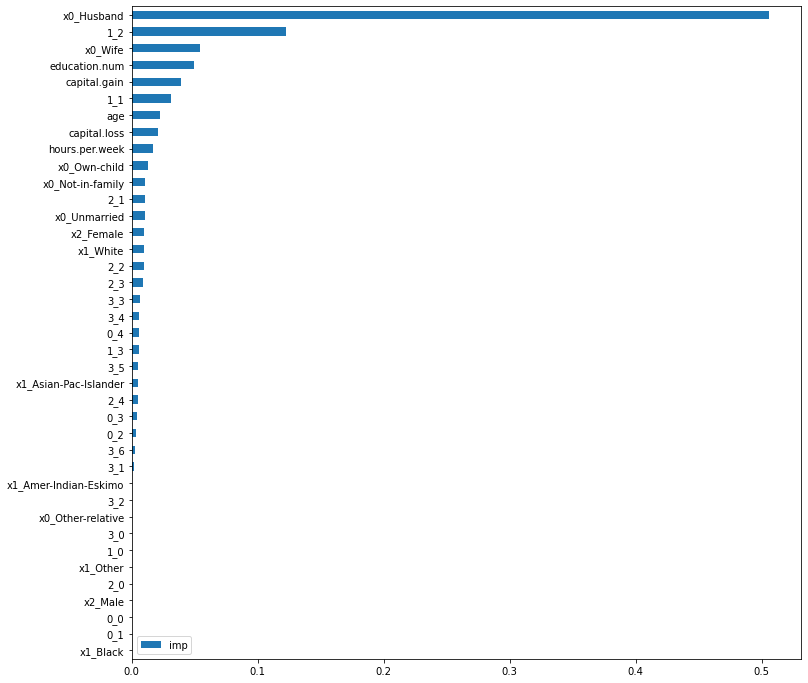

In [146]:
modeling_result(model_xgb)

## model selection

In [151]:
tree = DecisionTreeClassifier(max_depth = 3)

tree = DecisionTreeClassifier(max_depth = 3)
tree_ada = AdaBoostClassifier(
    tree,
    n_estimators = 200,
    learning_rate = 0.1,
    random_state = 10 
    )


model_gbc = GradientBoostingClassifier(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 3,
    random_state = 10
)


model_xgb = XGBClassifier(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 3,
    random_state = 10
)


estimator = Pipeline([
    ('preprocess', transformer),
    ('clf', tree)
])

skf = StratifiedKFold(n_splits=5)
hyperparam_space = {
    'clf' : [tree, tree_ada, model_gbc, model_xgb]
}

grid_model = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv = skf,
    scoring = 'f1',
    n_jobs = -1


)

In [152]:
grid_model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='NC',
                                                   

In [153]:
print(grid_model.best_score_)
print(grid_model.best_params_)

0.685971515916621
{'clf': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)}


## Hyperparam adaptive bossting

In [159]:
tree = DecisionTreeClassifier(max_depth = 3)
tree_ada = AdaBoostClassifier(
    tree,
    n_estimators = 200,
    learning_rate = 0.1,
    random_state = 10 
    )

estimator = Pipeline([
    ('preprocess', transformer),
    ('clf', tree_ada)
])

hyperparam_space = {
    'clf__learning_rate' : [0.1, 0.5, 0.2],
    'clf__n_estimators' : [200, 300, 400],
    'clf__base_estimator__max_depth' : [2,3,5]
}

tune_ada = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv = skf,
    scoring = 'f1',
    n_jobs = -1
)

In [160]:
tune_ada.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='NC',
                                                   

In [163]:
print(tune_ada.best_score_)
print(tune_ada.best_params_)

0.6941050137036004
{'clf__base_estimator__max_depth': 2, 'clf__learning_rate': 0.5, 'clf__n_estimators': 200}


## before after

In [164]:
best_model = tune_ada.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   BinaryEncoder())]),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupat

In [165]:
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17303
           1       0.75      0.65      0.70      5489

    accuracy                           0.86     22792
   macro avg       0.82      0.79      0.81     22792
weighted avg       0.86      0.86      0.86     22792



              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17303
           1       0.76      0.64      0.69      5489

    accuracy                           0.86     22792
   macro avg       0.82      0.79      0.80     22792
weighted avg       0.86      0.86      0.86     22792



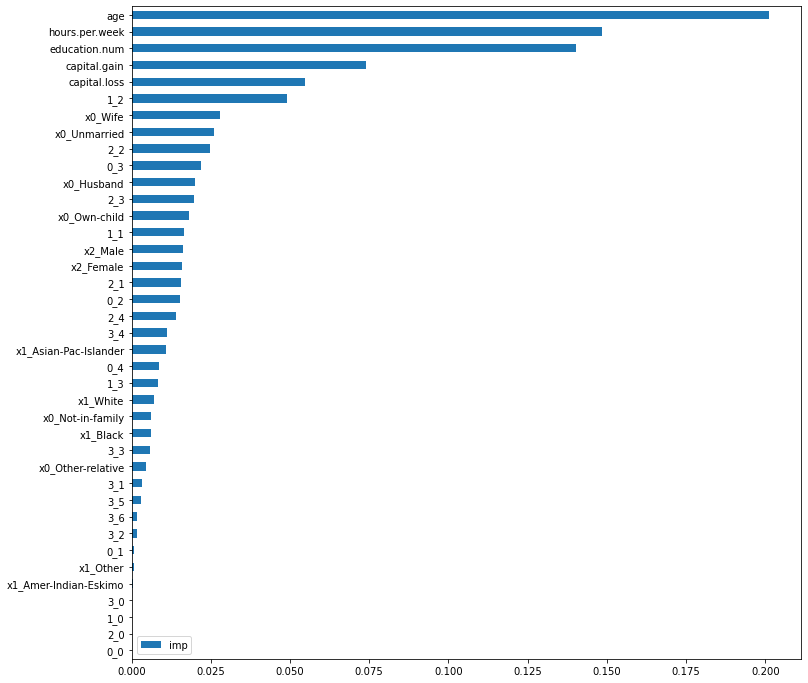

In [167]:
modeling_result(tree_ada)